## These models predict deltaI and deltaR using training data created with the MATLAB code ES_AG_Spec_v1 and a scale factor of 0.8993 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 

energy = (pd.read_csv('Training_Data/Graphene/GrapheneTrainingData180722_bias.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
# energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

# col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names

col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 

In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Graphene/ES_AG_Spec_data_180729_sf_0.8993.csv', header = None)
data1.drop(data1.iloc[:, 453:952], inplace=True, axis=1)
data1.columns = col_names1
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51161,0.51510,0.51873,0.52213,0.52612,0.52966,0.53340,0.53728,...,1.06200,1.05630,1.05100,1.04630,1.04220,1.0384,1.03500,1.03170,1.02840,1.02550
1,-0.14798,0.67080,0.56185,0.56681,0.57177,0.57643,0.58156,0.58619,0.59095,0.59570,...,1.04220,1.03750,1.03320,1.02930,1.02600,1.0231,1.02040,1.01790,1.01550,1.01350
2,-1.37130,0.52359,0.34715,0.34099,0.33582,0.33073,0.32660,0.32215,0.31841,0.31537,...,1.24940,1.23830,1.22810,1.21860,1.20990,1.2010,1.19200,1.18200,1.17110,1.16030
3,-0.13607,0.29882,0.68938,0.69978,0.70966,0.71879,0.72773,0.73596,0.74395,0.75169,...,0.99356,0.99153,0.98961,0.98804,0.98682,0.9858,0.98504,0.98431,0.98381,0.98353
4,-0.57749,0.70397,0.43491,0.43889,0.44332,0.44760,0.45257,0.45709,0.46194,0.46713,...,1.05510,1.04840,1.04210,1.03630,1.03120,1.0264,1.02190,1.01730,1.01290,1.00890


In [4]:
# Manipulating Training Data 
# col_names1a = ['deltaI', 'deltaR'] + energy_names[50:] # this would be used if we wanted to exclude the first peak 

#X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y1 = data1[['deltaI', 'deltaR', 'scale factor']]
X1 = data1.drop(['deltaI', 'deltaR'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

In [5]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)

In [6]:
# Checking Spec points Data 
X1.head()

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.51161,0.51510,0.51873,0.52213,0.52612,0.52966,0.53340,0.53728,0.54151,0.54539,...,1.06200,1.05630,1.05100,1.04630,1.04220,1.0384,1.03500,1.03170,1.02840,1.02550
1,0.56185,0.56681,0.57177,0.57643,0.58156,0.58619,0.59095,0.59570,0.60071,0.60534,...,1.04220,1.03750,1.03320,1.02930,1.02600,1.0231,1.02040,1.01790,1.01550,1.01350
2,0.34715,0.34099,0.33582,0.33073,0.32660,0.32215,0.31841,0.31537,0.31307,0.31035,...,1.24940,1.23830,1.22810,1.21860,1.20990,1.2010,1.19200,1.18200,1.17110,1.16030
3,0.68938,0.69978,0.70966,0.71879,0.72773,0.73596,0.74395,0.75169,0.75957,0.76672,...,0.99356,0.99153,0.98961,0.98804,0.98682,0.9858,0.98504,0.98431,0.98381,0.98353
4,0.43491,0.43889,0.44332,0.44760,0.45257,0.45709,0.46194,0.46713,0.47279,0.47804,...,1.05510,1.04840,1.04210,1.03630,1.03120,1.0264,1.02190,1.01730,1.01290,1.00890


In [7]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51161,0.51510,0.51873,0.52213,0.52612,0.52966,0.53340,0.53728,...,1.06200,1.05630,1.05100,1.04630,1.04220,1.0384,1.03500,1.03170,1.02840,1.02550
1,-0.14798,0.67080,0.56185,0.56681,0.57177,0.57643,0.58156,0.58619,0.59095,0.59570,...,1.04220,1.03750,1.03320,1.02930,1.02600,1.0231,1.02040,1.01790,1.01550,1.01350
2,-1.37130,0.52359,0.34715,0.34099,0.33582,0.33073,0.32660,0.32215,0.31841,0.31537,...,1.24940,1.23830,1.22810,1.21860,1.20990,1.2010,1.19200,1.18200,1.17110,1.16030
3,-0.13607,0.29882,0.68938,0.69978,0.70966,0.71879,0.72773,0.73596,0.74395,0.75169,...,0.99356,0.99153,0.98961,0.98804,0.98682,0.9858,0.98504,0.98431,0.98381,0.98353
4,-0.57749,0.70397,0.43491,0.43889,0.44332,0.44760,0.45257,0.45709,0.46194,0.46713,...,1.05510,1.04840,1.04210,1.03630,1.03120,1.0264,1.02190,1.01730,1.01290,1.00890


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.023649831374155845 for  deltaI Depth 60
R^2 Score on test data: 0.9971934113332558 for deltaI Depth 60
 
RMSE on test data: 0.022683442334349914 for  deltaR Depth 60
R^2 Score on test data: 0.9942241955134808 for deltaR Depth 60


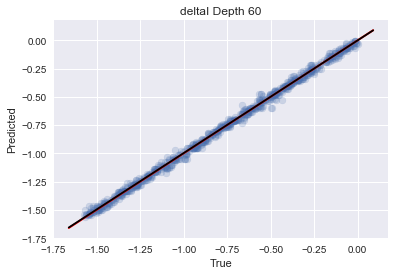

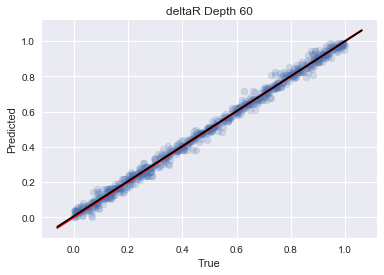

In [8]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [9]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)
features_sp_DT_sorted

,Spec - DT
E_-340_mV,0.532506
E_144_mV,0.106662
E_-174_mV,0.104726
E_376_mV,0.038383
E_-398_mV,0.034861
E_152_mV,0.032940
E_14_mV,0.028875
E_456_mV,0.009733
E_104_mV,0.009713
E_-166_mV,0.008649


## Random Forest

### spec points

 
RMSE on test data: 0.008192263590140395 for  deltaI RF spec
R^2 Score on test data: 0.9996632322424165 for deltaI RF spec
 
RMSE on test data: 0.009579014874959862 for  deltaR RF spec
R^2 Score on test data: 0.9989700022984153 for deltaR RF spec


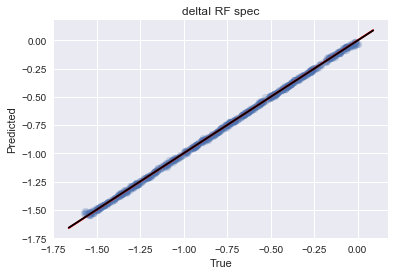

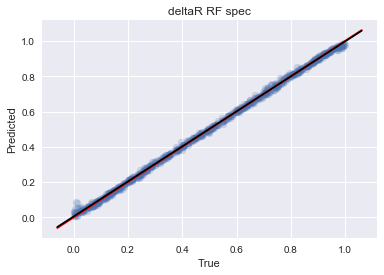

In [10]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [11]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)
features_sp_RF_sorted

,Spec - RF
E_-344_mV,0.125002
E_450_mV,0.107149
E_-340_mV,0.107085
E_-342_mV,0.071659
E_-336_mV,0.071343
E_454_mV,0.036946
E_-170_mV,0.022522
E_-172_mV,0.021779
E_-338_mV,0.018434
E_478_mV,0.018192


## Independent Random Forests

### spec points


Score - Random Forest: 0.9995097914502501 for deltaR IRF
 
RMSE on test data: 0.006608351887507873 for  deltaR 10
R^2 Score on test data: 0.9995097914502502 for deltaR 10
 
RMSE on test data: 0.004416734288749255 for  deltaI 10
R^2 Score on test data: 0.9999021129555613 for deltaI 10


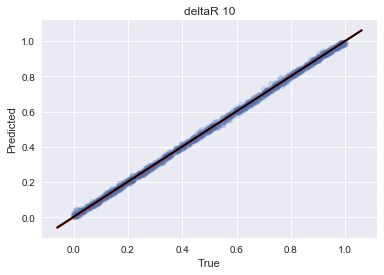

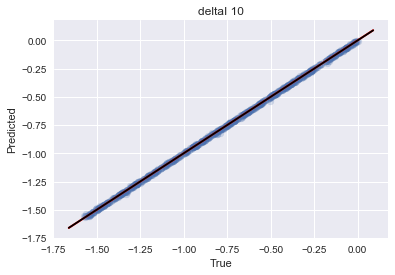

In [12]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [13]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)
#features_sp_RF2_sf_sorted

## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.0053649497025789515 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9998555711412401 for AdaBoost Delta I SP
 
RMSE on test data: 0.008042163822436816 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9992739936963813 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9998555711412401
Delta R AdaBoost Score: 0.9992739936963811


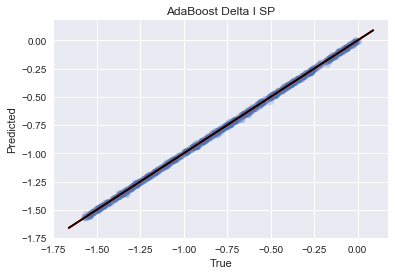

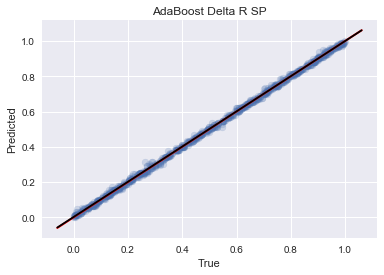

In [14]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [15]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)
#features_sp_AB_sf_sorted

## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.019919041710020746 for  GradientBoost Delta I SP
R^2 Score on test data: 0.99800905367344 for GradientBoost Delta I SP
 
RMSE on test data: 0.017175577882676676 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9966885570571924 for GradientBoost Delta R SP


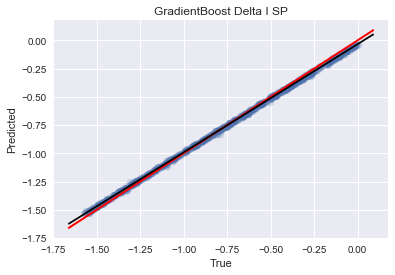

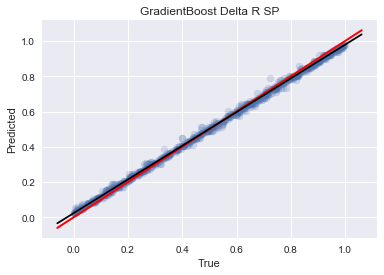

In [16]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [17]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)
#features_sp_GB_sf_sorted

In [18]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_-344_mV,0.125002
E_450_mV,0.107149
E_-340_mV,0.107085
E_-342_mV,0.071659
E_-336_mV,0.071343
E_454_mV,0.036946
E_-170_mV,0.022522
E_-172_mV,0.021779
E_-338_mV,0.018434
E_478_mV,0.018192


In [19]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_-344_mV,0.125002
E_450_mV,0.107149
E_-340_mV,0.107085
E_-342_mV,0.071659
E_-336_mV,0.071343
E_454_mV,0.036946
E_-170_mV,0.022522
E_-172_mV,0.021779
E_-338_mV,0.018434
E_478_mV,0.018192


In [20]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

## Testing the Models on the Experimental Data



In [24]:
# Load the experimental data
# Load experimental data
exp_data_sp = pd.read_csv('Training_Data/Graphene/ES_AG_Exp_data.csv', header = None, names = ['deltaI', 'deltaR']+energy_names+energy_names)
exp_data_sp = exp_data_sp.drop(['deltaI', 'deltaR'], axis = 1)
exp_data_sp.drop(exp_data_sp.iloc[:, 451:950], inplace=True, axis=1)



C:\Users\emory\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [25]:

exp_data_sp

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.74095,1.0937,0.98544,1.0485,1.0155,1.0431,1.0318,1.0431,1.0379,1.0407,...,1.0288,1.0306,1.0294,1.0369,1.0277,1.0427,1.0173,1.0542,0.99526,1.1068


In [26]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
 #                            r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T


In [27]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)


pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)



pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)


pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)


In [28]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])

In [29]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

In [30]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1],  RF_sp_di_r2score, RF_sp_dr_r2score)

In [31]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)


In [32]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score)


In [33]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)


In [34]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0],  GB_sp_di_r2score, GB_sp_dr_r2score)

In [35]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

In [36]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)


In [37]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.012036,0.077478,0.997193,0.994224
Random Forest spec points,-0.079541,0.221646,0.999663,0.998970
AdaBoost spec points,-0.165800,0.293807,0.999856,0.999274
Gradient Boosting spec points,-0.198369,0.288871,0.998009,0.996689
Independent Random Forests spec points,-0.175763,0.243027,0.999902,0.999510


In [38]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaR score'])

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.012036,0.077478,0.997193,0.994224
Gradient Boosting spec points,-0.198369,0.288871,0.998009,0.996689
Random Forest spec points,-0.079541,0.221646,0.999663,0.998970
AdaBoost spec points,-0.165800,0.293807,0.999856,0.999274
Independent Random Forests spec points,-0.175763,0.243027,0.999902,0.999510


In [39]:
# Predictions with 0.95 or lower scores excluded 
#GoodPredictedDeltaI = predictedPhases.drop([], axis = 0)
#GoodPredictedDeltaR = predictedPhases.drop([], axis = 0)
#GoodPredictedScaleFactor = predictedPhases.drop([], axis = 0)

GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  0.22457282091132771  +  -0.12620241991920006 *i


In [40]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Graphene/predictions_180722_sf.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Graphene/scores_180722_sf.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Graphene/predictions_180729_0.8993.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Graphene/scores_180729_0.8993.csv')




In [41]:
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_RF_= pd.Series(model_RF_sp.feature_importances_, index = X1_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_sp.feature_importances_, index = X1_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_sp.feature_importances_, index = X1_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_sp.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_sp.feature_importances_, index = X1_train.columns)
importance_ARF_i = pd.Series(model_AB_di_sp.feature_importances_, index = X1_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_sp.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_sp.feature_importances_, index = X1_train.columns)
importance_GRF_i = pd.Series(model_GB_di_sp.feature_importances_, index = X1_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_sp.feature_importances_, index = X_train.columns)

In [42]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-158_mV    1
E_92_mV      1
E_-88_mV     1
E_104_mV     1
E_12_mV      1
E_132_mV     1
E_144_mV     1
E_14_mV      1
E_-80_mV     1
E_152_mV     1
E_376_mV     1
E_38_mV      1
E_448_mV     1
E_452_mV     1
E_456_mV     1
E_478_mV     1
E_70_mV      1
E_34_mV      1
E_-6_mV      1
E_96_mV      1
E_-328_mV    1
E_-370_mV    1
E_-170_mV    1
E_-172_mV    1
E_-334_mV    1
E_-332_mV    1
E_-174_mV    1
E_74_mV      2
E_72_mV      2
E_-162_mV    2
E_-164_mV    2
E_454_mV     2
E_-168_mV    2
E_-396_mV    2
E_16_mV      2
E_-338_mV    2
E_-342_mV    2
E_-90_mV     2
E_-84_mV     2
E_-82_mV     2
E_-336_mV    3
E_450_mV     3
E_-344_mV    3
E_76_mV      3
E_-398_mV    3
E_-86_mV     3
E_-166_mV    4
E_-340_mV    5
dtype: int64

In [43]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

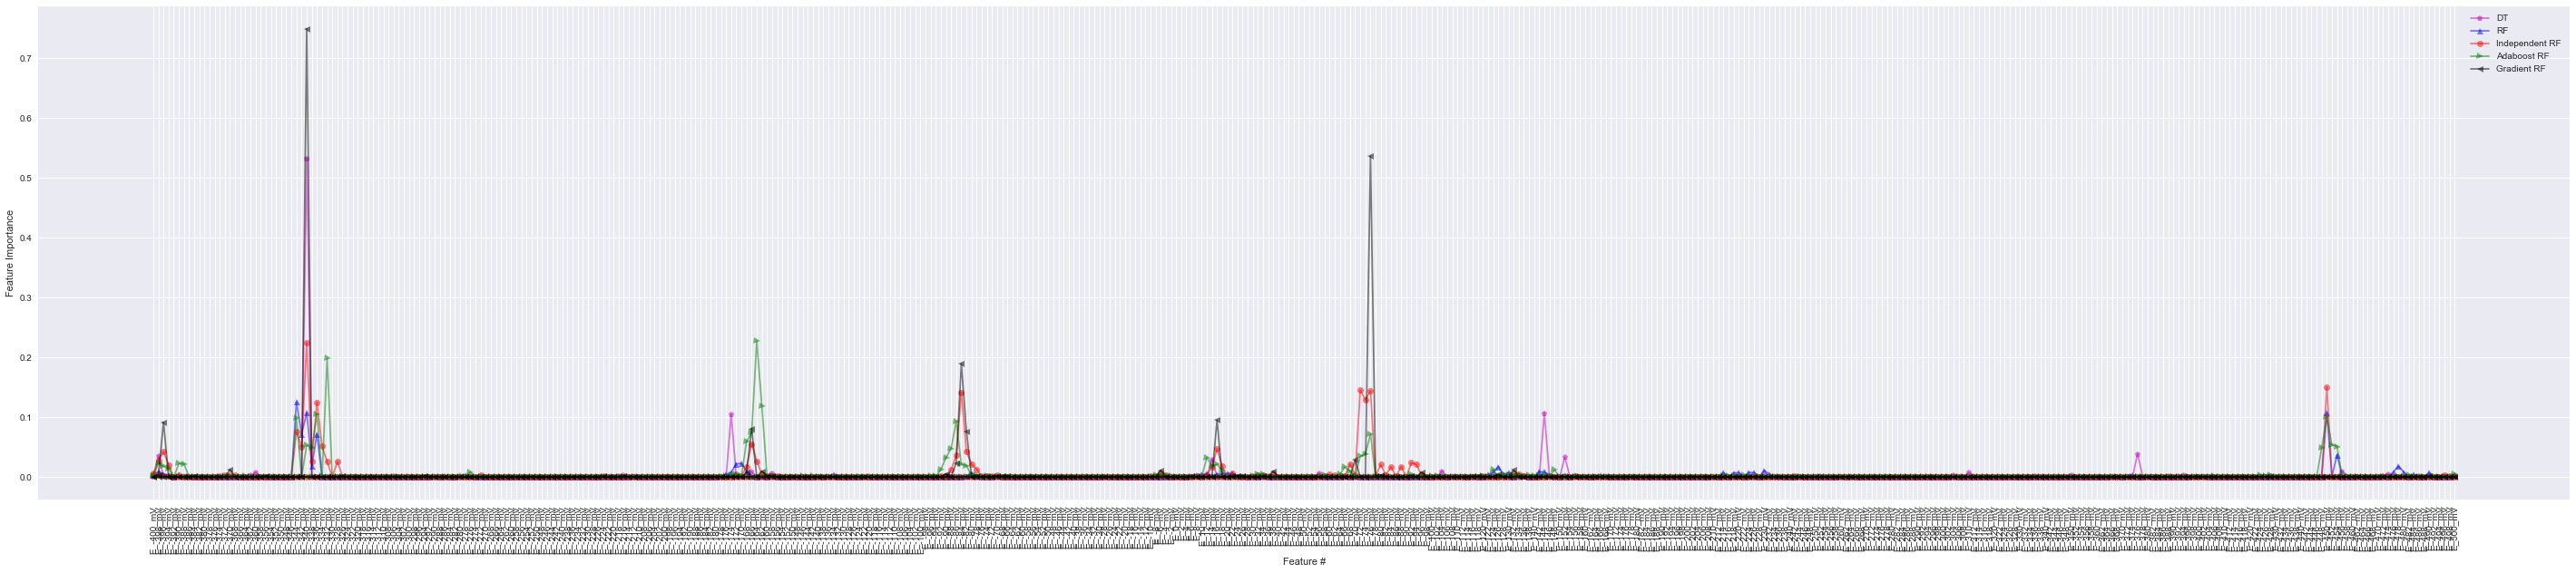

In [44]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

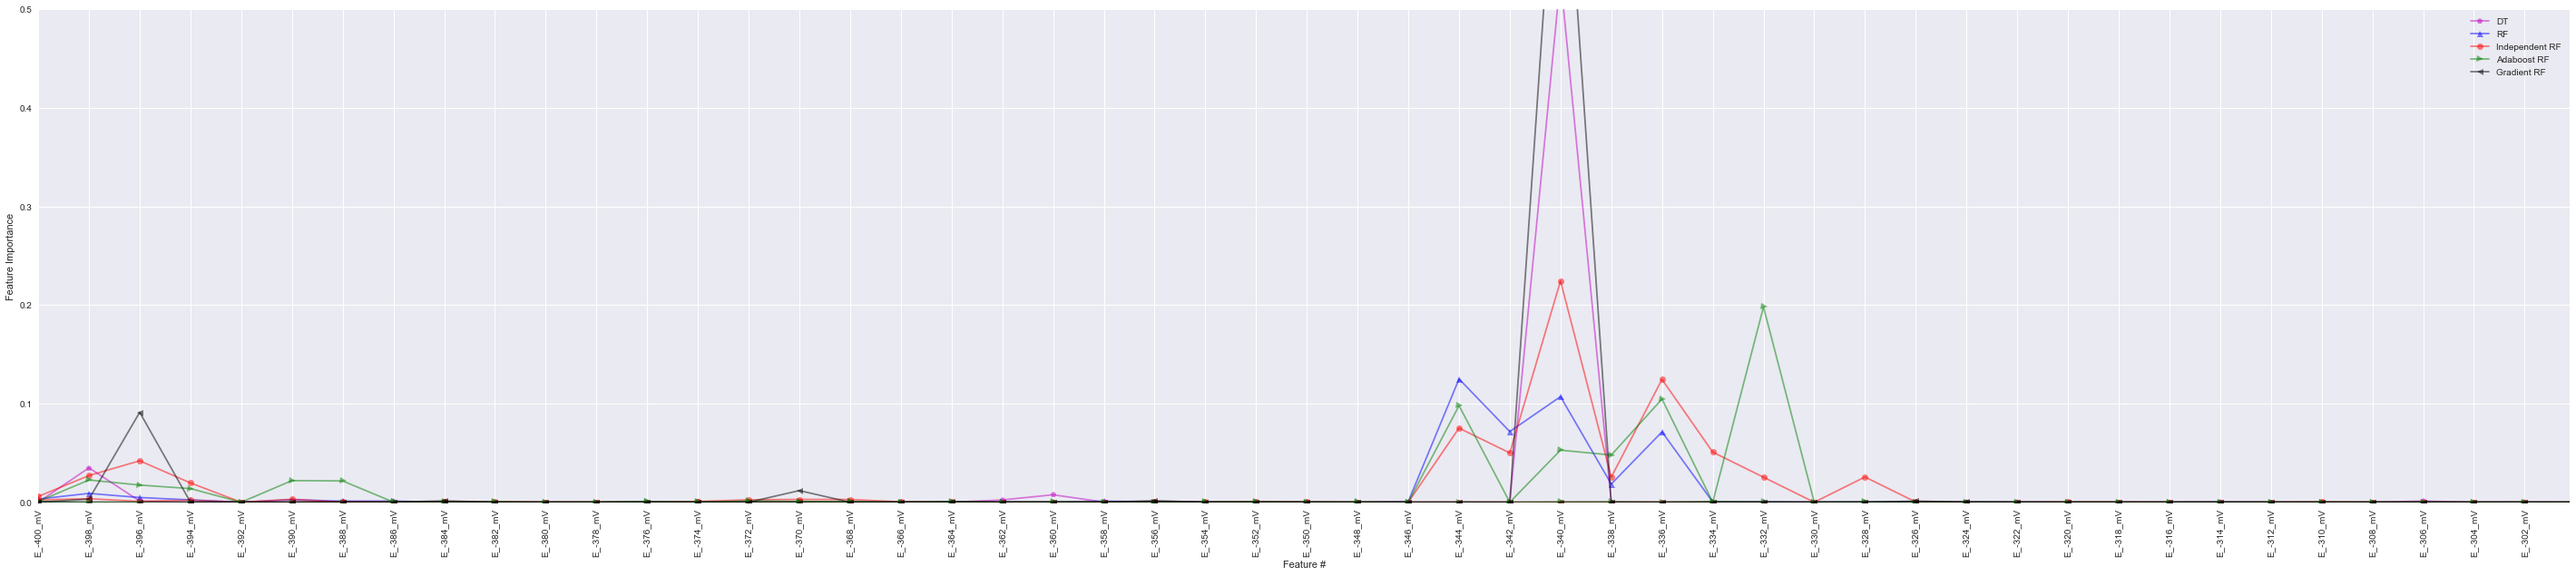

In [45]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.50])
xlim([0, 50])